# Imports

In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import IPython.display
import cv2
import pydicom._storage_sopclass_uids
import time

from os import walk
from ipywidgets import interact
from skimage.transform import radon, iradon, rescale
from datetime import datetime
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity

# Configuration

In [2]:
pic_dir = "photos/"
dicom_dir = "dicom_examples/"

# Loading and preprocess files

In [3]:
filenames = next(walk(pic_dir), (None, None, []))[2]  # [] if no file
images = dict()

for file in filenames:
    img = cv2.imread(pic_dir+file, cv2.IMREAD_GRAYSCALE)
    
    # fill backgorund
    h, _ = img.shape
    img = cv2.resize(img, (h,h))
    diagonal = np.round(np.sqrt(h**2 + h**2)).astype(int)
    new_shape = (diagonal, diagonal)
    large_img = np.zeros(new_shape)
    
    x0 = (diagonal - h) // 2
    y0 = (diagonal - h) // 2
    large_img[y0:y0+h, x0:x0+h] = img
    
    images[file.split('.')[0]] = img #large_img

# Bresenham algorithm

In [4]:
def bresenham(p1, p2):
    assert isinstance(p1, tuple), "First argument should be tuple"
    assert isinstance(p2, tuple), "Second argument should be tuple"
    
    x1, y1 = p1
    x2, y2 = p2
    pixels = []
    dx = abs(x2-x1)
    dy = abs(y2-y1)
    
    if x1 < x2: dir_x = 1
    else: dir_x = -1
        
    if y1 < y2: dir_y = 1
    else: dir_y = -1
    
    err = dx - dy
    
    while True:
        pixels.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e = 2 * err
        if e > -dy:
            err -= dy
            x1 += dir_x
        if e < dx:
            err += dx
            y1 += dir_y
    
    return pixels


# Radon transform
#### Parallel model
### Setting parameters

In [198]:
@interact
def set_parameters(_image=list(images.keys()),
                    _detectors=widgets.IntSlider(min=120,max=1000,step=60,value=500),
                    _phi=widgets.IntSlider(min=30,max=360,step=30,value=180),
                    _delta=widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1)):
    
    global delta, phi, detector_num, img
    delta = _delta # shift angle
    phi = _phi # span angle
    detector_num = _detectors # amount of detectors/emmiters in one iteration
    img = images[_image]
    
    plt.imshow(images[_image], cmap='gray')
    

interactive(children=(Dropdown(description='_image', options=('CT_ScoutView', 'Kolo', 'Kwadraty2', 'SADDLE_PE-…

### Sinogram filtering

In [6]:
def apply_filter(sinogram, kernel_size):
    kernel = [1 if k == 0 else 0 if k % 2 == 0 else ((-4/(np.pi**2)) / (k**2)) for k in range(-kernel_size//2+1, kernel_size//2+1)]
    filtered_sinogram = np.zeros_like(sinogram)
    
    for i in range(sinogram.shape[0]):
        filtered_sinogram[i,] = np.convolve(sinogram[i,], kernel, mode='same')
    
    return filtered_sinogram

### Min Max normalization

In [7]:
def MinMax(v):
    return (v - np.min(v)) / (np.max(v) - np.min(v))

### Run radon transform

In [160]:
def radon_transform(img, detector_num, delta, phi, show_iter=True, faster=True, filtering=False, kernel_size=None):
    
    if faster:
        img = rescale(img, scale=0.2) # rescaling image gives little worse effect but calculations are faster

    x0, y0 = img.shape[0] // 2, img.shape[1] // 2 # center coordinates
    angles = np.arange(0, 180, delta)
    sinogram = np.zeros((len(angles), detector_num))
    r = img.shape[0] / 2

    for i, alpha in enumerate(angles):
        angles_det = np.deg2rad(np.linspace(0, phi, detector_num) + alpha - phi/2)
        angles_emit = np.deg2rad(np.linspace(0, phi, detector_num) + alpha - phi/2 + 180)

        detectors = np.zeros((detector_num, 2), dtype=int)
        emitters = np.zeros((detector_num, 2), dtype=int)

        for j, (angle_det, angle_emit) in enumerate(zip(angles_det, angles_emit)):
            xd = np.round(r * np.cos(angle_det) - x0).astype(int)
            yd = np.round(r * np.sin(angle_det) - y0).astype(int)
            xe = np.round(r * np.cos(angle_emit) - x0).astype(int)
            ye = np.round(r * np.sin(angle_emit) - y0).astype(int)
            detectors[j][0], detectors[j][1] = xd, yd
            emitters[detector_num-j-1][0], emitters[detector_num-j-1][1] = xe, ye

        pixels = np.zeros(detector_num, None)
        for j, (det_coord, emit_coord) in enumerate(zip(detectors, emitters)):
            beam_coord = bresenham(tuple(det_coord), tuple(emit_coord))
            pixels[j] = np.sum([img[coord] for coord in beam_coord])
        
        sinogram[i,] = pixels
        
        if show_iter:
            plt.imshow(sinogram.T, cmap='gray')
            plt.show()
            IPython.display.clear_output(wait=True)
            
    if filtering:
        if not kernel_size:
            kernel_size = len(angles)
        sinogram = apply_filter(sinogram, kernel_size)
            
    return sinogram

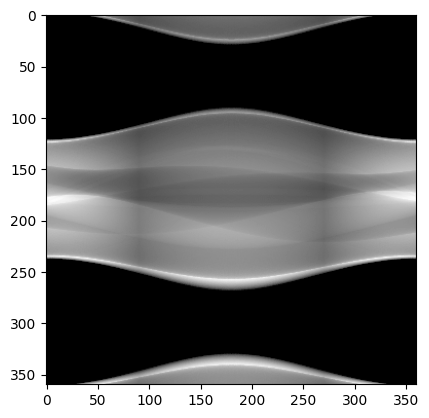

In [207]:
sinogram = radon_transform(img, detector_num, delta, phi, faster=False, filtering=False, show_iter=True)

In [208]:
filtered_sinogram = apply_filter(sinogram, sinogram.shape[0])

#### Estimate the best kernel size for filtering

In [10]:
check_kernel_size = False

if check_kernel_size:
    
    for k in range(1, sinogram.shape[0]-1, 2):
        sin = apply_filter(sinogram.T, k)
        plt.imshow(inverse_radon_transform(sin,delta,show_iter=False), cmap='gray')
        plt.title(f"Size: {k}")
        plt.show()
        IPython.display.clear_output(wait=True)

In most cases longer kernels gives better results.

# Inverse radon

In [11]:
# http://rknet.pl/student/2013_2014/pom/wyk/POM_Radon_Hough.pdf

In [163]:
def inverse_radon_transform(sinogram, delta, out_scale=5.0, show_iter=True):
    
    angles = np.arange(0, 180, delta)
    detectors_num = sinogram.shape[1]
    size = np.round(np.sqrt((detectors_num) ** 2 / out_scale)).astype('int')
    reconstr_img = np.zeros((size, size))
    x0, y0 = np.mgrid[:size, :size] - size // 2
    x = np.arange(detectors_num) - detectors_num // 2
    angles = np.deg2rad(angles)

    for col, angle in zip(sinogram, angles):
        s = -x0 * np.sin(angle) + y0 * np.cos(angle)
        # t = x0 * np.cos(angle) + y0 * np.cos(angle)
        reconstr_img += np.interp(s, x, col)
       
        if show_iter:
            plt.imshow(reconstr_img, cmap='gray')
            plt.show()   
            IPython.display.clear_output(wait=True)
        
    return reconstr_img

In [209]:
reconstructed = inverse_radon_transform(sinogram, delta, show_iter=False)
reconstructed_filtered = inverse_radon_transform(filtered_sinogram, delta, show_iter=False)

In [54]:
def calculate_rmse(original_img, reconstructed):
    return np.sqrt(np.mean((reconstructed - original_img)**2))

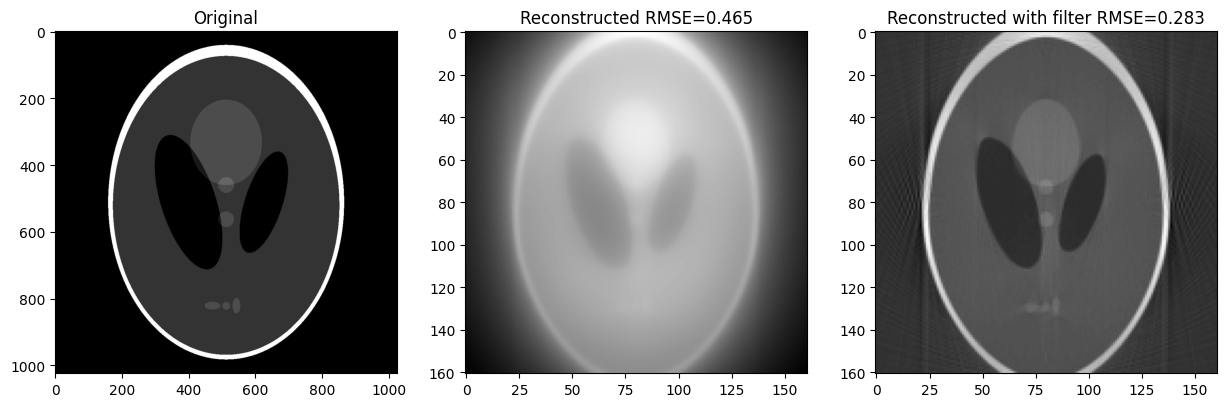

In [210]:
def compare(original_img, reconstructed, reconstructed_filtered, saveimg=False, filename='Default.png'):
    
    fig, ax = plt.subplots(1,3, figsize=(15,8))
    ax[0].imshow(original_img, cmap='gray')
    ax[0].set_title('Original')
    
    r = calculate_rmse(MinMax(cv2.resize(original_img, reconstructed.shape)), MinMax(reconstructed))
    rf = calculate_rmse(MinMax(cv2.resize(original_img, reconstructed.shape)), MinMax(reconstructed_filtered))
    
    ax[1].imshow(reconstructed, cmap='gray')
    ax[1].set_title(f'Reconstructed RMSE={np.round(r,3)}')

    ax[2].imshow(reconstructed_filtered, cmap='gray')
    ax[2].set_title(f'Reconstructed with filter RMSE={np.round(rf,3)}')
    
    if saveimg:
        plt.savefig(filename)
    else:    
        plt.show()
    
compare(img, reconstructed, reconstructed_filtered)

#### Comparison with skimage built-in function

In [53]:
@interact
def radon_check(image=list(images.keys())):
    plt.figure(figsize=(10,3))
    
    plt.subplot(1,3,1)
    img  = rescale(images[image], scale=0.2)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(1,3,2)
    sinogram = radon(img)
    plt.imshow(sinogram, cmap='gray')
    
    plt.subplot(1,3,3)
    reconstr = iradon(sinogram)
    plt.imshow(reconstr, cmap='gray')
    
    plt.show()

interactive(children=(Dropdown(description='image', options=('CT_ScoutView', 'Kolo', 'Kwadraty2', 'SADDLE_PE-l…

# Save and read DICOM

In [249]:
def convert_image_to_ubyte(img):
    return img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))

def save_as_dicom(file_name, img, patient_data):
    img_converted = convert_image_to_ubyte(img)
    
    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = FileDataset(None, {}, preamble=b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    
    ds.PatientName = patient_data["PatientName"]
    ds.PatientID = patient_data["PatientID"]
    ds.ImageComments = patient_data["ImageComments"]
    ds.StudyDate = patient_data["StudyDate"]

    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7

    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = img_converted.shape

    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

    ds.PixelData = img_converted.tobytes()

    ds.save_as(file_name, write_like_original=False)
    
    print('Image saved successfully')
    
def read_dicom(filename):
    ds = pydicom.dcmread(filename)
    return ds.pixel_array
    

#### Save

In [253]:
filename = input("Enter file name: ")
patient_data = {}
patient_data["PatientName"] = input("Enter patient name: ")
patient_data["PatientID"] = input("Enter patient id: ") # str(np.random.randint(0,10000))
patient_data["ImageComments"] = input("Enter comments: ")
patient_data["StudyDate"] = datetime.now().date().strftime('%Y%m%d')

dicom_img = convert_image_to_ubyte(reconstructed_filtered)
save_as_dicom(dicom_dir+filename+'.dcm', dicom_img, patient_data)

Enter file name:  Brain_
Enter patient name:  John
Enter patient id:  8397
Enter comments:  ...


Image saved successfully


#### Read

In [255]:
filenames = next(walk(dicom_dir), (None, None, []))[2]
dicom_images = dict()
dicom_data = dict()

for file in filenames:
    dicom_img = read_dicom(dicom_dir+file)
    dicom_images[file.split('.')[0]] = dicom_img
    
    d_data = pydicom.dcmread(dicom_dir+file)
    dicom_data[file.split('.')[0]] = d_data

In [256]:
@interact
def overview(_image=list(dicom_images.keys())):
    
    ds = dicom_data[_image]
    img = dicom_images[_image]    
    plt.imshow(img, cmap='gray')
    print(ds)
    

interactive(children=(Dropdown(description='_image', options=('Kropka', 'SADDLE_PE', 'Kwadraty2', 'CT_ScoutVie…

### Experiment

In [174]:
default_detectors = 180
default_phi = 180
default_scans = 180

detectors = np.arange(90, 720+1, 90)
scans = np.arange(90, 720+1, 90)
phis = np.arange(45, 270+1, 45)

kernel_size=50

exp_dir = 'experiment_dir/'

In [175]:
def experiment_pipeline(img, det, sc, ph, kernel_size, fname):
    delta = 180 / sc
    sinogram = radon_transform(img, det, delta, ph, show_iter=False, faster=True)
    filtered_sinogram = apply_filter(sinogram, kernel_size)
    reconstructed = inverse_radon_transform(sinogram, delta, show_iter=False)
    filtered_reconstructed = inverse_radon_transform(filtered_sinogram, delta, show_iter=False)
    compare(img, reconstructed, filtered_reconstructed, saveimg=True, filename=fname)
    
    rmse = calculate_rmse(MinMax(cv2.resize(img, reconstructed.shape)), MinMax(reconstructed))
    rmse_f = calculate_rmse(MinMax(cv2.resize(img, reconstructed_filtered.shape)), MinMax(reconstructed_filtered))

    return rmse, rmse_f

##### Scans

In [ ]:
rmse = []
rmse_f = []

for i, scan in enumerate(scans):
    err, errf = experiment_pipeline(img, default_detectors, scan, default_phi, kernel_size, f'{exp_dir}Scans_{i}_{scan}')
    rmse.append(err)
    rmse_f.append(errf)


In [ ]:
plt.plot(scans, rmse)
plt.xlabel("Number of scans")
plt.ylabel("RMSE")
plt.savefig('Scans.png')
plt.show()

plt.plot(scans, rmse_f)
plt.xlabel("Number of scans")
plt.ylabel("RMSE")
plt.savefig('Scans_f.png')

##### Detectors

In [ ]:
rmse = []
rmse_f = []

for i, detector in enumerate(detectors):
    err, errf = experiment_pipeline(img, detector, default_scans, default_phi, kernel_size, f'{exp_dir}Detectors_{i}_{scan}')
    rmse.append(err)
    rmse_f.append(errf)

In [ ]:
plt.plot(detectors, rmse)
plt.xlabel("Number of detectors")
plt.ylabel("RMSE")
plt.savefig('Detectors.png')
plt.show()

plt.plot(detectors, rmse_f)
plt.xlabel("Number of detectors")
plt.ylabel("RMSE")
plt.savefig('Detectors_f.png')

##### Phi's

In [ ]:
rmse = []
rmse_f = []

for i, phi in enumerate(phis):
    err, errf = experiment_pipeline(img, default_detectors, default_scans, phi, kernel_size, f'{exp_dir}Phi_{i}_{scan}')
    rmse.append(err)
    rmse_f.append(errf)

In [ ]:
plt.plot(phis, rmse)
plt.xlabel("Span angle")
plt.ylabel("RMSE")
plt.savefig('Phis.png')
plt.show()

plt.plot(phis, rmse_f)
plt.xlabel("Span angle")
plt.ylabel("RMSE")
plt.savefig('Phis_f.png')